In [150]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from utils import BboxSelector

from sentinelhub import SentinelHubRequest, SentinelHubDownloadClient, DataSource, MimeType, DownloadRequest, CRS, BBox

In [168]:
selector = BboxSelector(BBox(bbox=[10.3670, 42.7116, 10.3945, 42.7266], crs=CRS.WGS84))
selector.show()

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [184]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "REFLECTANCE"
            }],
            output: {
                bands: 3,
                sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2017-06-01T07:12:03', '2017-06-15T07:12:04'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=selector.bbox,
    size=selector.size
)

In [185]:
img = request.get_data(max_threads=3)[0]

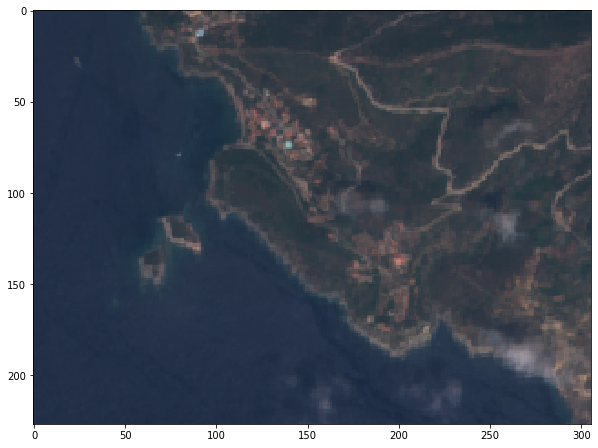

In [186]:
plt.figure(figsize=(10,10))
plt.imshow(img, vmin=0, vmax=1);

In [187]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "DN"
            }],
            output: {
                bands: 3,
                sampleType: "UINT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2017-06-01T07:12:03', '2017-06-15T07:12:04'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON)
    ],
    bbox=selector.bbox,
    size=selector.size
)

In [188]:
tar = request.get_data(max_threads=3)[0]

In [189]:
tar.keys()

dict_keys(['default.tif', 'userdata.json'])

In [190]:
tar_img = tar['default.tif'].astype(np.float32)
norm_factor = tar['userdata.json']['norm_factor']

In [191]:
tar_img = tar_img * norm_factor

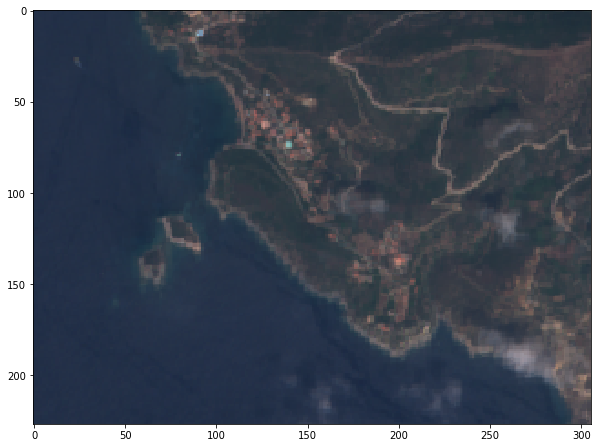

In [192]:
plt.figure(figsize=(10,10))
plt.imshow(tar_img * 2.5, vmin=0, vmax=1);

In [193]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "DN"
            }],
            output: {
                bands: 3,
                sampleType: "UINT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_body = SentinelHubRequest.body(
    evalscript=evalscript,
    request_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2017-06-01T07:12:03', '2017-06-15T07:12:04'),
            mosaicking_order='leastCC'
        )
    ],
    request_output=SentinelHubRequest.output(
        size=selector.size,
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
            SentinelHubRequest.output_response('userdata', MimeType.JSON)
        ],
    ),
    request_bounds=SentinelHubRequest.bounds(selector.bbox)
)

In [194]:
download_request = DownloadRequest(
    request_type='POST',
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_body,
    data_type=MimeType.TAR,
    headers={'content-type': 'application/json', "accept": 'application/tar'}
)

In [195]:
client = SentinelHubDownloadClient()

In [196]:
result = client.download(download_request)

In [197]:
tar_img = result['default.tif'].astype(np.float32)
norm_factor = result['userdata.json']['norm_factor']
tar_img = tar_img * norm_factor

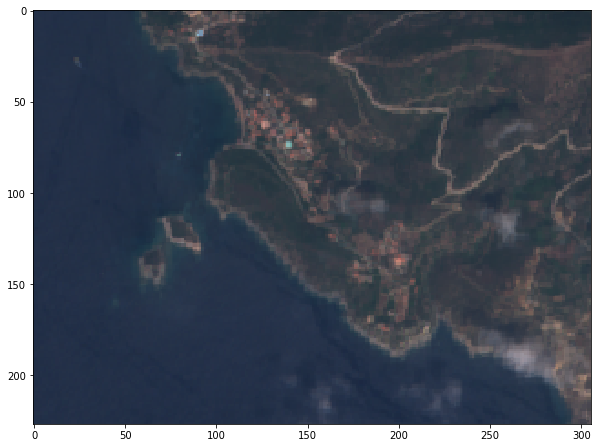

In [198]:
plt.figure(figsize=(10,10))
plt.imshow(tar_img * 2.5, vmin=0, vmax=1);